In [3]:
using CSV, StatsBase, DataFrames,PythonPlot,DifferentialEquations,LinearAlgebra
include("./simulations.jl")

data = CSV.read("./output/data_processed.csv",DataFrames.DataFrame);
lineages = unique(data.lineage);

# Functions

## Interpolation

In [2]:
function align_vectors(vectors, grid_length) 
    # takes as inpput a list of variable length vectors 
    # and aligns then to a grid with 1:3 intrepolation

    # Determine the range of the new uniform grid
    grid = collect(1:grid_length)
    
    # Align all vectors to the new grid
    aligned_vectors = [interpolate_vector(vec, grid) for vec in vectors]

    return hcat(aligned_vectors...)
end

# Linear interpolation function
function interp1d(x, y,xi)
    if xi <= x[1]
        return y[1]
    elseif xi >= x[end]
        return y[end]
    else
        for i in 1:length(x)-1
            if x[i] <= xi <= x[i+1]
                return y[i] + (y[i+1] - y[i]) * (xi - x[i]) / (x[i+1] - x[i])
            end
        end
    end
end

function interpolate_vector(vector, grid)
    # Create the original grid for the vector
    original_grid =  collect(1:length(vector))

    # Perform linear interpolation
    interp_vector = [interp1d(original_grid, vector, x) for x in grid]
    return interp_vector
end


interpolate_vector (generic function with 1 method)

# Model and data generation

In [790]:
function F(du, u, p, t)
    # Model parameters.
    α_R,α_Q,α_C = p
    du[1] =  α_R*u[1]
    du[2] =  α_Q*u[1]
    du[3] =  α_C*u[1]
    du[4] = 0.0

    return nothing
end
function G(du,u,p,t)
    α_R,α_Q,α_C = p
    du[1] =  sqrt(α_R*u[1])
    du[2] =  sqrt(α_Q*u[1])
    du[3] =  sqrt(α_C*u[1])
    du[4] =  0.0
end

c_crit = 60
function condition(u, t, integrator) # Event when condition(u,t,integrator) == 0
    c_crit - u[3]
end

function affect!(integrator)
    u = integrator.u
    u[1] = u[1]/2
    u[2] = u[2]/2 
    u[3] = c_crit/2
    u[4] = u[4] + 1
    nothing
end

callback = ContinuousCallback(condition, affect!);



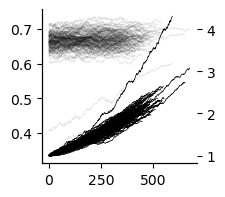

In [848]:
# generate data
init = [50,50,50,0]
θ = [10,2.0,3.0]
prob = SDEProblem(F,G,init,(0,10),θ)
sol = solve(prob,callback = callback)
u = hcat(sol.u...)';

# put in dataframe
df = DataFrame(u,["uR","uQ","uC","position"])
df[:,"time"] = sol.t;
df[:,:y] = df[:,:uR]+df[:,:uQ] + df[:,:uQ];


# plot
fig,ax = subplots(figsize=(2,2),sharex=true)
inds = unique(df[:,:position])
ax2 = ax.twinx()

for pos in inds
    df_cell = df[df.position .== pos,:]
    
    ax2.plot(1:length(df_cell.time),df_cell.uR/df_cell.uR[1],"-",color="k",lw=0.5)
    ax.plot(1:length(df_cell.time),df_cell.uR ./ (df_cell.uR .+ df_cell.uC .+ df_cell.uQ),color="k",lw=0.5,alpha=0.1)
end
ax2.spines["right"].set_visible(false)
ax.spines["right"].set_visible(false)
ax2.spines["top"].set_visible(false)
ax.spines["top"].set_visible(false)
#ax.plot(sol.t,u[:,2])
fig

In [849]:
function loss(p)
    tmp_prob = remake(prob, p = p)
    tmp_sol = solve(tmp_prob, SOSRI(), saveat = 0.1, trajectories = 1000)
    arrsol = Array(tmp_sol)
    sum(abs2, truemean - mean(arrsol, dims = 3)) +
    0.1sum(abs2, truevar - var(arrsol, dims = 3)),
    arrsol
end

function cb2(p, l, arrsol)
    @show p, l
    means = mean(arrsol, dims = 3)[:, :]
    vars = var(arrsol, dims = 3)[:, :]
    p1 = plot(sol[1].t, means', lw = 5)
    scatter!(p1, sol[1].t, truemean')
    p2 = plot(sol[1].t, vars', lw = 5)
    scatter!(p2, sol[1].t, truevar')
    p = plot(p1, p2, layout = (2, 1))
    display(p)
    false
end


# Reduced dimensional representations

In [850]:
function dimension_reduce(y,t)
    L_grid = length(t)
    X = hcat([ones(L_grid),t]...);
    b = inv(X'*X)*X'*Y[:,2]
    dy = y .- X*b;
    X2sin = hcat([sin.(2*pi*k .*time_grid) for k in 1:3]...);
    X2cos = hcat([cos.(2*pi*k .*time_grid) for k in 1:3]...);
    X2 = hcat(X2sin,X2cos)
    b2 = inv(X2'*X2)*X2'*dy;
    X = hcat(X,X2)
    b = vcat(b,b2)
    return X,b
end

dimension_reduce (generic function with 1 method)

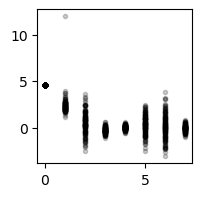

In [855]:
B = hcat([dimension_reduce(Y[:,k],T[:,k])[2] for k in 1:length(Y[1,:])]...);
#B = B ./ sum(B,dims=1)
fig, ax = subplots(figsize=(2,2))
ax.plot(B,"k.",alpha=0.2)
fig


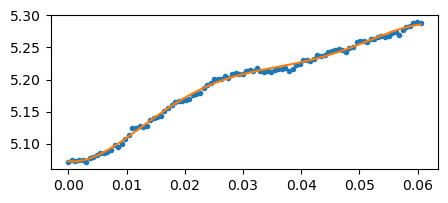

In [844]:
X,b = dimension_reduce(Y[:,10],T[:,10])
fig, ax = subplots(figsize=(5,2))
ax.plot(T[:,10],Y[:,10],".")
ax.plot(T[:,10],X*b)
fig

In [845]:
# get sim Y matrix
df[:,:y] = df[:,:uR]+df[:,:uQ] + df[:,:uQ]
dfs = groupby(df,:position)
L = length(dfs)
Y = [df[:,:y] for df in dfs]
Y = log.(align_vectors(Y,100))

# get data Y matrix
l1210_lin = data[data.lineage .== lineages[1],:];
l1210s = groupby(l1210_lin,:position)
L_l1210 = length(dfs)
Y_l1210 = [df[:,:lnM] for df in l1210s]
Y_l1210 = align_vectors(Y_l1210,100);

We want a loss that minimizes the distance between samples $Y$ and our simulations $\tilde{Y}$. We can do this naively by ignoring information about position in the lineages, meaning that we can treat each of the columns as iid sample. Then the problem becomes about measuring the difference between two samples. 

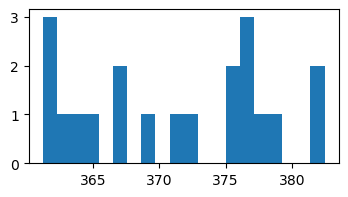

In [572]:
fig, ax= subplots(figsize=(4,2))
z = [sum(Y_l1210[:,k]) for k in 1:length(Y_l1210[1,:])]
ax.hist(z[3:end],20)
std(z)/mean(z)
fig


In [672]:
function dimension_reduction(df,ind,grid)

    # get y raw
    y = df[df.position .== ind,:y]
    n_grid = length(y) 
    gen_time = df[df.position .==ind,:time][end] - df[df.position .==ind,:time][1]
    time_grid = collect(0:gen_time/(n_grid-1):gen_time)
    X = hcat([ones(n_grid),time_grid]...);
    b = inv(X'*X)*X'*Y[:,2]
    dy = Y[:,2] .- X*b;
    X2sin = hcat([sin.(2*pi*k .*time_grid) for k in 1:6]...);
    X2cos = hcat([cos.(2*pi*k .*time_grid) for k in 1:6]...);
    X2 = hcat(X2sin,X2cos)
    b2 = inv(X2'*X2)*X2'*dy;
    X = hcat(X,X2)
    b = vcat(b,b2)

Base.Meta.ParseError: ParseError:
# Error @ /Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE_PAPERS/L1210_growth_rate_fluctuations/L1210/src/simulations_examples.ipynb:16:19
    X = hcat(X,X2)
    b = vcat(b,b2)
#                 └ ── Expected `end`

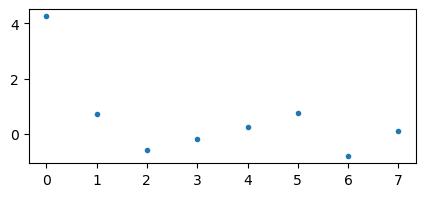

In [671]:
fig, ax= subplots(figsize=(5,2))
#ax.plot(X[:,2],Y[:,2],".")
#ax.plot(X[:,2],X*b,"-")
plot(b,".")
fig

In [669]:
plot(b)

Python: [<matplotlib.lines.Line2D object at 0x15a3dd790>]